In [1]:
# installing necessary libraries
from tensorflow.keras.applications import EfficientNetB0
import os 
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import TensorBoard
from tqdm import tqdm
from tensorflow.keras import mixed_precision
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import seaborn as sns

# seting global policy
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

# check whether machine has gpu or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# creating tensorboard callback and model checkpoint
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True
                                            #  verbose=1
                                             )
    return m_c

train_df = pd.read_csv('C:/thesis2_code_repo/dataset/train.csv')
# train_img_path = 'C:/thesis2_code_repo/dataset/train_images'

sns.set(rc={'figure.figsize':(25,8.40)})
sns.set(style='darkgrid')
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 20
BATCH_SIZE = 16
IMAGE_SIZE = [224, 224]
# Seed
SEED = 42
# Learning rate
LR = 0.001
# Verbosity
VERBOSE = 2


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce GTX 1650 Ti, compute capability 7.5
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


### Helper functions

In [2]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

# display some images from a batch
def show_img_from_batch(dataset, num_of_images):
    image_batch, label_batch = next(iter(dataset)) # iterate each batch in the dataset
    plt.figure(figsize=(10, 10))
    for i in tqdm(range(num_of_images)):
        ax = plt.subplot(3, 3, i + 1)
#         print(image_batch[i].numpy())
        plt.imshow(image_batch[i].numpy().astype("float32"))
        label = label_batch[i]
        plt.title(label_batch[i].numpy().astype('int32'))
        plt.axis("off")

#plot to visualize the loss and accuracy against number of epochs
def plot_hist(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

### Removal of duplicate rows

In [3]:
# removal of duplicate rows
train_df.drop_duplicates(subset = ['image'], inplace = True) # length of 32412
train_df.reset_index(drop = True, inplace = True)
train_df.head(2)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045


### Number of items per class

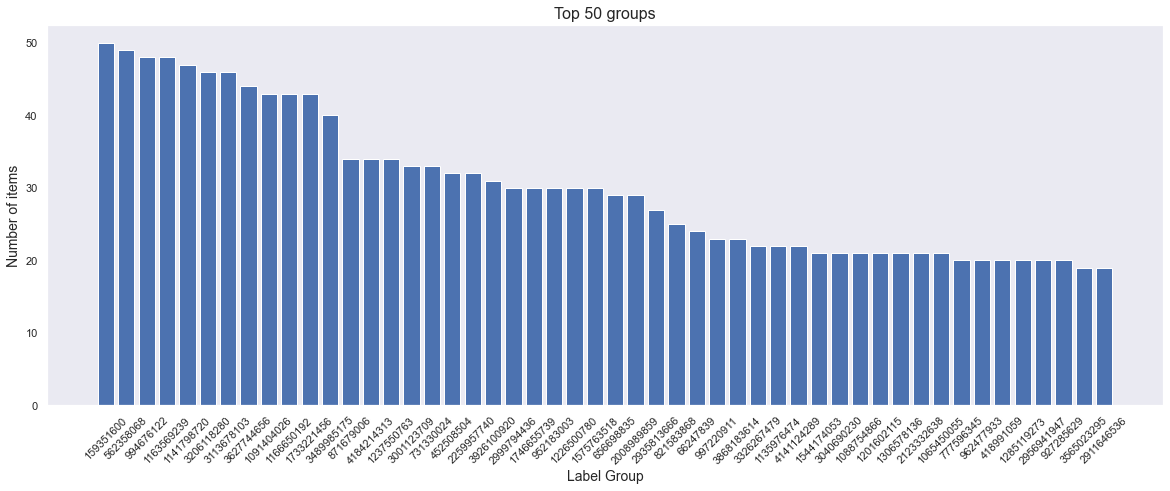

In [4]:
def display_most_populated_classes(train_dataframe, class_num=10, title="Title"):
    groups = train_dataframe.label_group.value_counts()
    plt.figure(figsize=(20,7))
    plt.bar(groups.index.values[:class_num].astype('str'), groups.values[:class_num])
    plt.xticks(rotation = 45)
    plt.ylabel('Number of items',size=14)
    plt.xlabel('Label Group',size=14)
    plt.grid()

    plt.title(title,size=16)
    plt.show()

display_most_populated_classes(train_df, class_num=50,title="Top 50 groups")

### Selecting 50 classes to use, and selecting images

In [5]:
label_count_df = train_df.label_group.value_counts().rename_axis('label_group').reset_index(name='count')
class_list = list(label_count_df['label_group'][:50])
train = train_df.loc[train_df['label_group'].isin(class_list)]
print("Train Length: ", len(train))
img_labels = list(train['label_group'])

Train Length:  1511


In [6]:
train.head()

,posting_id,image,image_phash,title,label_group
48,train_3497907844,007be583a5a4edc3fc54b0779e141a9f.jpg,9ba6cc31a427a675,ARSHOP MAYCREATE MOISTURIZING UV SPRAY 150ML (...,1141798720
59,train_1734882388,008a7e4f77c10f36ace0314cff98ba09.jpg,da00a03e871f9f37,TZUKI SOAP 1 PCS,3489985175
71,train_3043787667,00a798efae9db3d6d5324daebfea2652.jpg,e9949669b54a199d,SABUN TZUKI,3489985175
78,train_2806016221,00b558da33ffb34b620b0b5e79420c23.jpg,bc3cc2c991c3ec27,Spon blender / Sponge beauty blender / spons m...,4141124289
81,train_4175229751,00b9f86046a30f68841671d510077cc6.jpg,a9b6c30b36f03b49,\xe2\x9d\xa4 RATU \xe2\x9d\xa4 MAYCREATE MOIST...,1141798720


### saving classes to seperate folders

In [7]:
unique_labels = list(train['label_group'].unique())
len(unique_labels)

50

In [8]:
# import os
# import numpy as np
# import shutil
# dest_dir = 'C:/thesis2_code_repo/thesis/images_revision'
# root_dir = 'C:/thesis2_code_repo/dataset/train_images'

# for i in unique_labels:
#     new_folder = dest_dir +'/train/' + str(i)
#     os.makedirs(new_folder)
#     images_paths = root_dir + "/" + train['image'][train['label_group'] == i]
#     ## loop through the entire image dataset, and copy images of the class i
#     for image in images_paths:
#         shutil.copy(image, new_folder)



### Loading new dataset

In [9]:

dataset_rev_path = 'C:/thesis2_code_repo/dataset_rev/images_data'

import os
# os.walk(dataset_rev_path)
labels = os.listdir(dataset_rev_path)
labels = [int(i) for i in labels]
print("classes length: ", len(labels))

classes length:  50


In [10]:

def create_training_data():
    training_data = []

    for label in labels:
        path = os.path.join(dataset_rev_path, str(label))
        class_num = labels.index(label)
        # print(path)
        for img in os.listdir(path):
            current_image_path = path + '/' + img
            try:
                if (img.endswith('.jpg') or img.endswith('.jpeg') ):
                    training_data.append([label, img, current_image_path])
            except Exception as e:
                print("error")
                pass

    return training_data

training_data = create_training_data()
print("Length training_data: ", len(training_data))


Length training_data:  4841


In [11]:

def check_file_type():
    file_types = []

    for label in labels:
        path = os.path.join(dataset_rev_path, str(label))
        class_num = labels.index(label)
        # print(path)
        for img in os.listdir(path):
            if (img.endswith('.jpg') or img.endswith('.jpeg') ):
                file_types.append([label, img])

    return file_types

file_types = check_file_type()
len(file_types)

4841

### create dataframe based on training_data

In [12]:
train_rev = pd.DataFrame(training_data, columns=['label_group', 'image', 'file_path'])
train_rev.head()

,label_group,image,file_path
0,1065450055,1df49cbb01d34c063b508e0c99c67aa9.jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...
1,1065450055,1PC Cute Mini Portable Heat Sealer....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...
2,1065450055,1pc Portable Heat Sealer Plastic Bag... (1).jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...
3,1065450055,1pc Portable Heat Sealer Plastic Bag....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...
4,1065450055,1pc Portable Travel Toothbrush Protect....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...


### displaying revised dataset

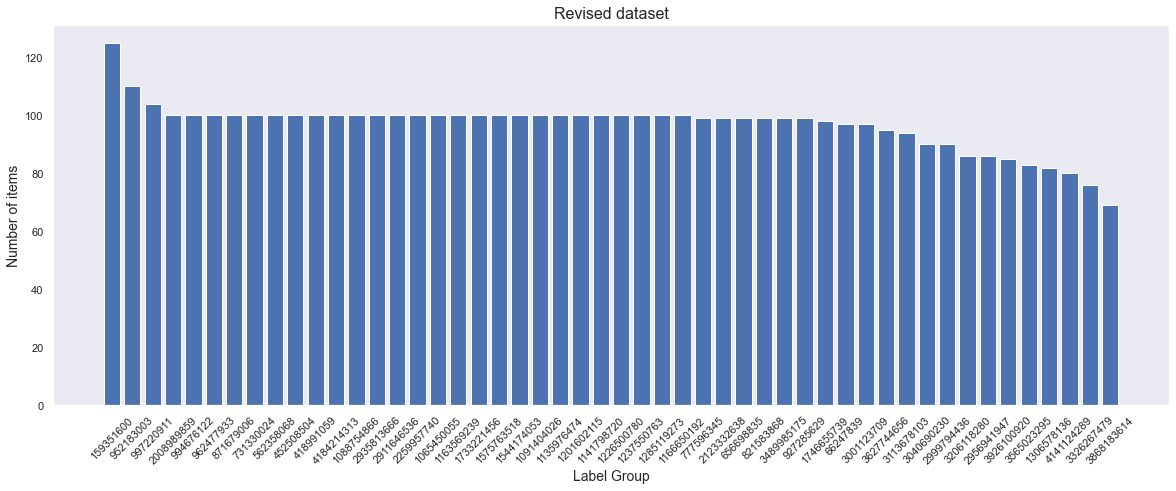

In [13]:
display_most_populated_classes(train_rev, class_num=50, title="Revised dataset")

### Normalize labels

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
image_labels = le.fit_transform(list(train_rev['label_group']))
# image_labels = utils.to_categorical(image_labels)
label_mapper = dict(zip(le.classes_, le.transform(le.classes_)))
# print(label_mapper)
train_rev['label_encoded'] = image_labels


In [15]:
train_rev.head()

,label_group,image,file_path,label_encoded
0,1065450055,1df49cbb01d34c063b508e0c99c67aa9.jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
1,1065450055,1PC Cute Mini Portable Heat Sealer....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
2,1065450055,1pc Portable Heat Sealer Plastic Bag... (1).jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
3,1065450055,1pc Portable Heat Sealer Plastic Bag....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
4,1065450055,1pc Portable Travel Toothbrush Protect....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15


### Processing images

In [16]:
# loading image, and resizing by 224 x 224
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE) # 224x224
    return image

# read image file and apply decode_image
def read_image(image, label_group):
    image = tf.io.read_file(image)
    image = decode_image(image)
    return image, label_group

# read image only, no label_group
def read_image_only(image):
    image = tf.io.read_file(image)
    image = decode_image(image)
    return image

# used for y pred, by returning image and label_group seperately. used tensor_slices, and did no switch to tensor
def get_test_data(image, label_group):
    # image = file path
    images = tf.data.Dataset.from_tensor_slices(image)
    images = images.map(read_image_only, num_parallel_calls = AUTO)
    images = images.batch(BATCH_SIZE)
    images = images.prefetch(AUTO)
    
    labels = tf.data.Dataset.from_tensor_slices(label_group)
    labels = labels.batch(BATCH_SIZE)
    labels = labels.prefetch(AUTO)
    
    return images, labels

def display_dataset_info(trn_image, val_image, trn_labels, val_labels):
    print("trn_image: ", len(trn_image))
    print("val_image: ", len(val_image))
    print("trn_labels: ", len(trn_labels))
    print("val_labels: ", len(val_labels))
    print("\n")
    
def train_and_eval_split(image, label_group):
    X_train, X_valid, y_train, y_valid = train_test_split(image, label_group, random_state=SEED, shuffle=True, stratify=label_group, test_size=0.20 )

    display_dataset_info(X_train, X_valid, y_train, y_valid)
    return X_train, X_valid, y_train, y_valid

# getting training dataset, by converting a portion of data into tensors
def get_training_dataset(image, label_group):
    dataset = tf.data.Dataset.from_tensor_slices((image, label_group))
    dataset = dataset.map(read_image, num_parallel_calls = AUTO) # replaced the first element into array of numbers
#     dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048) # shuffling the train dataset
    dataset = dataset.batch(BATCH_SIZE) # batching the sizes
    dataset = dataset.prefetch(AUTO) # prefetch means loading in advance or something

    return dataset

# Get our validation dataset, almost same functions as get_training_dataset()
def get_validation_dataset(image, label_group):
    dataset = tf.data.Dataset.from_tensor_slices((image, label_group))
    dataset = dataset.map(read_image, num_parallel_calls = AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_dataset(image, label_group, file_paths):
    X_train, X_valid, y_train, y_valid= train_and_eval_split(file_paths, label_group)
    display_dataset_info(X_train, X_valid, y_train, y_valid)
    train_dataset = get_training_dataset(X_train, y_train)
    val_dataset = get_validation_dataset(X_valid, y_valid)
#     show_img_from_batch(val_dataset, 3)

    return image, train_dataset, val_dataset, [X_train, X_valid, y_train, y_valid]

### Get Dataset

In [17]:
train_rev.head(1)

,label_group,image,file_path,label_encoded
0,1065450055,1df49cbb01d34c063b508e0c99c67aa9.jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15


In [18]:
image, train_dataset, val_dataset, x_and_y_data = get_dataset(train_rev['image'], train_rev['label_encoded'], train_rev['file_path'])
X_train, X_valid, y_train, y_valid = x_and_y_data[0], x_and_y_data[1], x_and_y_data[2], x_and_y_data[3]
print("Length of csv file: ", len(train_rev))
print("Class count: ", 50)

trn_image:  3872
val_image:  969
trn_labels:  3872
val_labels:  969


trn_image:  3872
val_image:  969
trn_labels:  3872
val_labels:  969


Length of csv file:  4841
Class count:  50


In [19]:
train_rev.head(3)


,label_group,image,file_path,label_encoded
0,1065450055,1df49cbb01d34c063b508e0c99c67aa9.jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
1,1065450055,1PC Cute Mini Portable Heat Sealer....jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15
2,1065450055,1pc Portable Heat Sealer Plastic Bag... (1).jpg,C:/thesis2_code_repo/dataset_rev/drive-downloa...,15


In [20]:
# train_dataset, val_dataset


In [21]:
img_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1), 
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2), 
        layers.experimental.preprocessing.RandomContrast(factor=0.1), 
    ], name='img_augmentation')

### Get model

In [22]:
# # getting the base model
# def get_base_model(train_dataset, val_dataset, epoch_count=20):
#     base_model = EfficientNetB0(include_top=False, weights='imagenet')
#     base_model.trainable = False
#     inputs = layers.Input(shape = (224, 224, 3), name="inputLayer")
#     # x = img_augmentation(inputs)
#     x = base_model(inputs, training=False)
#     x = layers.GlobalAveragePooling2D(name="poolingLayer")(x)

#     x = layers.Dense(256, activation='relu', name='denseLayer')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5, name="top_dropout1")(x)

#     x = layers.Dense(128, activation='relu', name='denseLayer2')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5, name="top_dropout2")(x)

#     x = layers.Dense(50, name='outputLayer')(x)
#     outputs = layers.Activation(activation='softmax', dtype=tf.float32, name='activationLayer')(x)
#     model = tf.keras.Model(inputs, outputs, name="FeatureExtractionModel")
#     print(model.summary())
    
#     # print layer trainability
#     for lnum, layer in enumerate(model.layers):
#         print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

#     model.compile(
#         optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
#         loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
#         metrics = ["accuracy"]
#     )
#     print('\n')
#     print('-'*50)
#     # Seed everything
#     seed_everything(SEED)
#     STEPS_PER_EPOCH = len(image) // BATCH_SIZE              #32412 // 32 = 1012
#     K.clear_session()

#     history = model.fit(train_dataset,
#                             steps_per_epoch = STEPS_PER_EPOCH,
#                             epochs = epoch_count,
#                             validation_data = val_dataset,
#                             # verbose = VERBOSE,
#                             callbacks=[tensorboard_callback("Tensorboard","model"), 
#                                         model_checkpoint("Checkpoints","model.ckpt")],
#                             verbose=1
#                             )
    
#     print('\n')
#     print('-'*50)
#     print('Training Complete...')

#     return model, history

In [23]:
# getting the base model
def get_model(length_images, train_dataset, val_dataset, epoch_count=10):
    inputs = layers.Input(shape = (224, 224, 3), name="inputLayer")
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

    # model.trainable = False

    # rebuild top
    x = layers.GlobalAveragePooling2D(name="poolingLayer")(model.output)
    x = layers.Dense(256, activation='relu', name='denseLayer')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout1")(x)

    x = layers.Dense(128, activation='relu', name='denseLayer2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout2")(x)

    x = layers.Dense(50, name='outputLayer')(x)
    outputs = layers.Activation(activation='softmax', dtype=tf.float32, name='activationLayer')(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    # print(model.summary())
    

    # testing mode
    # print layer trainability
    # for lnum, layer in enumerate(model.layers):
    #     print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = ["accuracy"]
    )
    print('\n')
    print('-'*50)
    # Seed everything
    seed_everything(SEED)
    STEPS_PER_EPOCH = length_images // BATCH_SIZE              #32412 // 32 = 1012
    K.clear_session()
    # print("STEPS_PER_EPOCH: ",STEPS_PER_EPOCH)

    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = epoch_count,
                            validation_data = val_dataset,
                            # verbose = VERBOSE,
                            callbacks=[tensorboard_callback("Tensorboard","model"), 
                                        model_checkpoint("Checkpoints","model.ckpt")],
                            verbose=1
                            )
    
    print('\n')
    print('-'*50)
    print('Training Complete...')
    history =0

    return model, history

In [24]:
base_model, history_base = get_model(len(train_rev['file_path']),train_dataset, val_dataset)



--------------------------------------------------
Epoch 1/10


C:\Users\Nathan\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


302/302 [==============================] - 122s 342ms/step - loss: 2.0279 - accuracy: 0.5101 - val_loss: 0.5417 - val_accuracy: 0.8679
Epoch 2/10
302/302 [==============================] - 101s 334ms/step - loss: 0.6805 - accuracy: 0.8324 - val_loss: 0.2728 - val_accuracy: 0.9143
Epoch 3/10
302/302 [==============================] - 302s 1s/step - loss: 0.4758 - accuracy: 0.8758 - val_loss: 0.3593 - val_accuracy: 0.9082
Epoch 4/10
302/302 [==============================] - 101s 333ms/step - loss: 0.4746 - accuracy: 0.8742 - val_loss: 0.4469 - val_accuracy: 0.8885
Epoch 5/10
302/302 [==============================] - 101s 335ms/step - loss: 0.3811 - accuracy: 0.9000 - val_loss: 0.3466 - val_accuracy: 0.9082
Epoch 6/10
302/302 [==============================] - 103s 343ms/step - loss: 0.3412 - accuracy: 0.9075 - val_loss: 0.2819 - val_accuracy: 0.9154
Epoch 7/10
302/302 [==============================] - 214s 709ms/step - loss: 0.3725 - accuracy: 0.8994 - val_loss: 0.2767 - val_accuracy:

In [1]:
# plot_hist(history_base)

In [2]:
# history_dict = history_base.history
# history_df_base_model = pd.DataFrame.from_dict(history_dict)
# history_df_base_model